(200, 200, 3)


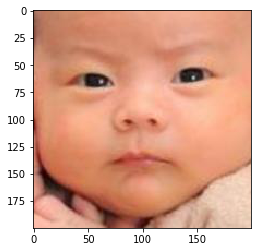

In [12]:
import imageio
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

im = imageio.imread('face_age/001/1000.png')
print(im.shape)

plt.imshow(im, interpolation='nearest')
plt.show()

In [13]:
data_dir = "face_age"

batch_size = 32
img_height = 200
img_width = 200

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9778 files belonging to 99 classes.
Using 7823 files for training.
Found 9778 files belonging to 99 classes.
Using 1955 files for validation.


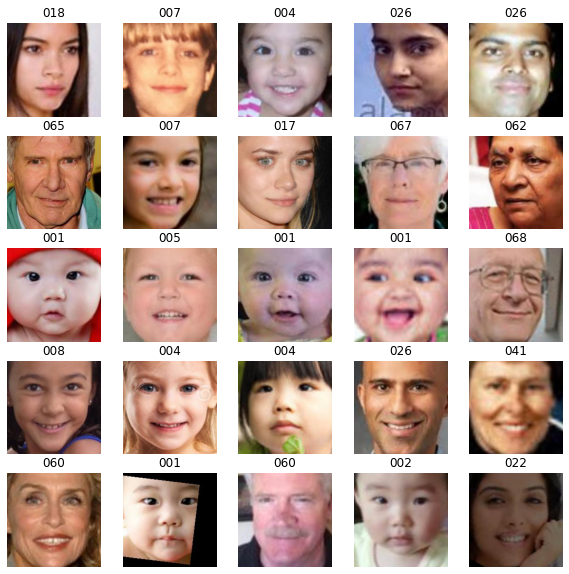

In [14]:
# Shows 25 random images from the training dataset
def display_data():
    class_names = train_ds.class_names
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            
display_data()

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

# keeps images in memory after they are loaded in the first epoch.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
normalization_layer = layers.Rescaling(1. / 255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

0.0 0.97647065
